In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from Utils import Domain, PSGD, calculate_regret, estimate_gradient

**Demonstration of gradient estimation**

In [2]:
f = lambda x: np.linalg.norm(x)**2 
x = np.array([1.0, 2.0, 3.0])
print(estimate_gradient(f, x))

[2. 4. 6.]


**Example Optimization Problem**:

Using the Pentagon for an example domain, and $$f_t(x) = \left(1+ \frac{1}{t}\right)\|x\|^2$$ 
which is $2-$strongly convex because $$f_t - \frac{\alpha}{2}\|x\|^2 = \frac{\|x\|^2}{t}$$ is convex. Using the horizon $T=100$, and bounds $R=\sqrt{5},G=4R$, we have $$\eta = \frac{R}{G\sqrt{T}}$$ for PSGD and using the strong convexity, $$\eta_{t+1} = \frac{1}{\alpha  t}.$$ 
For the regular convexity $\eta$ case, we use the doubling trick to get $\eta$ as the higher rate on $[2^k,2^{k+1}]$. 

(1, 2)
(100, 2)


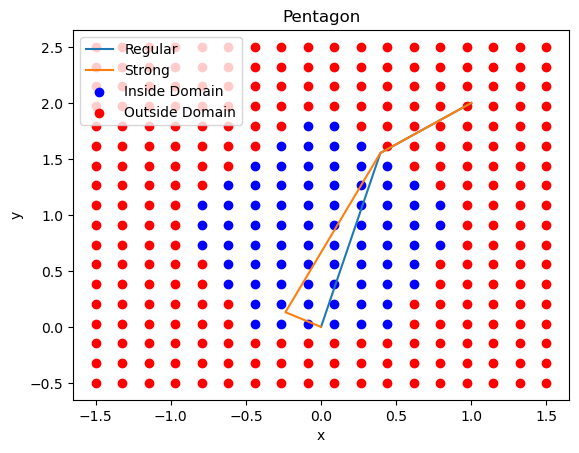

In [3]:
#create a pentagon using hyperplanes 
def hyperplanes(x: np.ndarray)-> np.ndarray:
    assert x.shape[0] == 2
    y = np.zeros(5)
    y[0] = 2*x[0]  - x[1] -1
    y[1] = -2*x[0] - x[1]  -1
    y[2] = -x[1] 
    y[3] = x[1] - x[0]  -2
    y[4] = x[0] + x[1] -2 
    return y  

levels = np.array([1.0,1.0,0.0,2.0,2.0])
Pentagon = Domain(dimension=2,level_function=hyperplanes,level=0,bounds=np.array([[-1.5,1.5],[-.5,2.5]])) 


#create optimization problem with f(x,t) = (1+1/t)*||x||^2 
horizon = 100
f = lambda t,x: (1+1/t)*np.linalg.norm(x)**2
x = np.zeros((horizon,2))
x0 = np.array([1.0,2.0])
R = np.sqrt(5)  #bound on norm of x
G = 4*R         #bound on Gradients 
alpha = 2.0     #strong convexity 
samples = 20    #number of samples for discretization 

def eta(R,G,time: int)-> float:
    k = np.floor(np.log2(time)) 
    return R/(G*np.sqrt(k)) 

eta_strong = lambda t: 1/(alpha*(t-1))
eta_reg = lambda t: eta(R,G,t)

projections = lambda x: Pentagon.project_point(x,num_samples=samples)

reg_opt = PSGD(C=Pentagon,f=f,x0=x0,eta=eta_reg,projection_fn=projections)
strong_opt = PSGD(C=Pentagon,f=f,x0=x0,eta=eta_strong,projection_fn=projections)


#run the optimization 
reg_avg_regret = []
strong_avg_regret = []

for t in range(2,horizon+1):
    reg_opt.run(t)
    strong_opt.run(t)
    if t % 10 == 0:
        #calculate regret
        
        reg_regret, _ = calculate_regret(f,Pentagon,reg_opt.x,t,num_samples=samples)
        strong_regret, _ = calculate_regret(f,Pentagon,strong_opt.x,t,num_samples=samples)
        reg_avg_regret.append([t,reg_regret/t])
        strong_avg_regret.append([t,strong_regret/t])


#unsqueeze x0 to be shape 1x2 
x0 = np.expand_dims(x0,axis=0)
print(x0.shape)
print(reg_opt.x.shape)
reg_guess = np.append(x0,reg_opt.x,axis=0)
strong_guess = np.append(x0,strong_opt.x,axis=0)

_, min_x_reg = calculate_regret(f,Pentagon,reg_opt.x,horizon,num_samples=100)
_, min_x_strong = calculate_regret(f,Pentagon,strong_opt.x,horizon,num_samples=100) 
assert (min_x_reg == min_x_strong).all()   #should be the same

#plot the points and then the pentagon 
plt.plot(reg_guess[:,0],reg_guess[:,1],label='Regular')
plt.plot(strong_guess[:,0],strong_guess[:,1],label='Strong')
Pentagon.visualize_2dim(num_samples=18,name='Pentagon')


**Metrics** 

Now we plot the guesses with closer detail by examining the norms as the optimal point is the origin. Then we look at the average regret of each. 

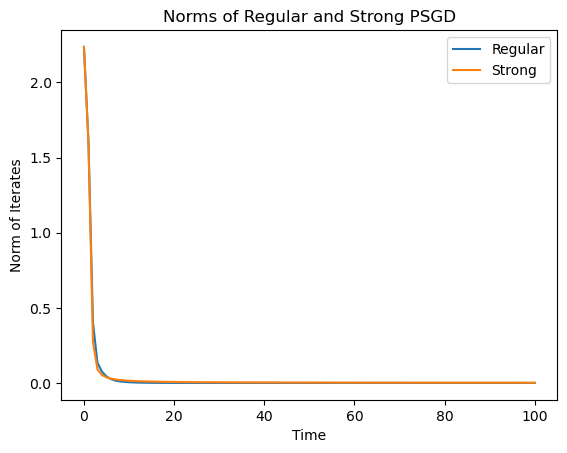

In [4]:
#plot the norms of regular and strong guesses 
norms_reg = np.linalg.norm(reg_guess,axis=1)
norms_strong = np.linalg.norm(strong_guess,axis=1)
plt.figure()
plt.plot(norms_reg,label='Regular')
plt.plot(norms_strong,label='Strong')
plt.xlabel('Time')
plt.ylabel('Norm of Iterates')
plt.legend()
plt.title('Norms of Regular and Strong PSGD')
plt.show()

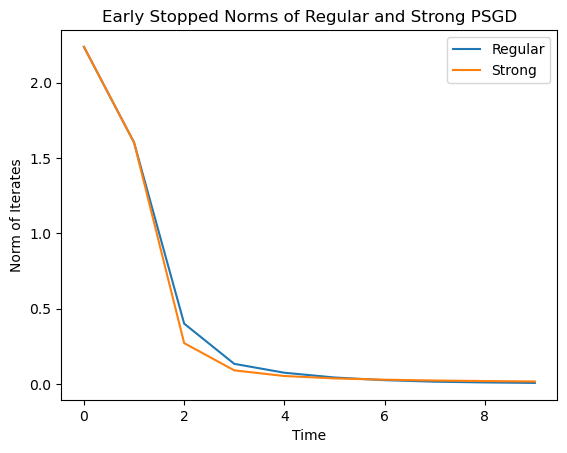

In [5]:
early_stop = 10         #stop early for visualization
plt.figure()
plt.plot(norms_reg[:early_stop],label='Regular')
plt.plot(norms_strong[:early_stop],label='Strong')
plt.xlabel('Time')
plt.ylabel('Norm of Iterates')
plt.legend()
plt.title('Early Stopped Norms of Regular and Strong PSGD')
plt.show()

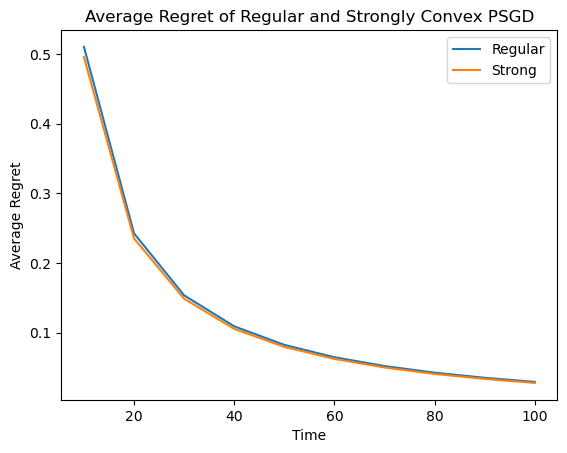

In [6]:
#plot the average regret lists 
reg_avg_regret = np.array(reg_avg_regret)
strong_avg_regret = np.array(strong_avg_regret)
plt.figure()
plt.plot(reg_avg_regret[:,0],reg_avg_regret[:,1],label='Regular')
plt.plot(strong_avg_regret[:,0],strong_avg_regret[:,1],label='Strong')
plt.xlabel('Time')
plt.ylabel('Average Regret')
plt.title('Average Regret of Regular and Strongly Convex PSGD')
plt.legend()

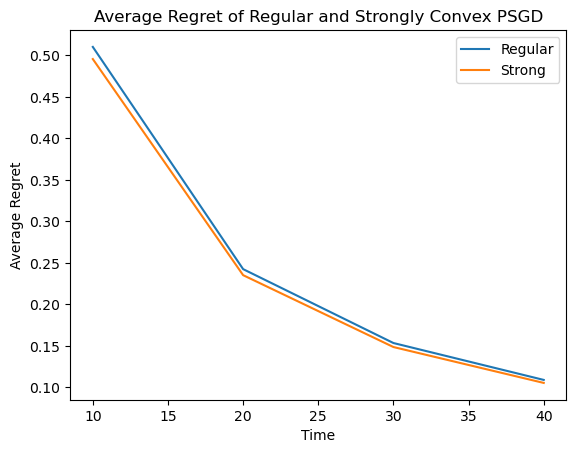

In [7]:
#early stop it
plt.figure()
plt.plot(reg_avg_regret[:4,0],reg_avg_regret[:4,1],label='Regular')
plt.plot(strong_avg_regret[:4,0],strong_avg_regret[:4,1],label='Strong')
plt.xlabel('Time')
plt.ylabel('Average Regret')
plt.title('Average Regret of Regular and Strongly Convex PSGD')
plt.legend()
